# Adversarial Attack

В этом ноутбуке мы рассмотрим один из простейших методов "обмана" нейросетей.

Идея в том, чтобы оптимизировать входное изображение таким образом, чтобы обученная CNN начала выдавать желаемый для нас класс объекта.

In [1]:
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision as tv

from PIL import Image
import numpy as np
import os

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# загружаем названия классов датасета ImageNet

classes = {}
for line in open('./data/adversarial/imagenet1000.txt'):
    line = line.replace('{', '').replace('}', '')
    idx, name = line.strip().split(':')
    name = name.replace("'", "").replace(',', '')
    classes[int(idx)] = name.strip()

In [3]:
# модели, представленные в torchvision.models, были обучены на
# изображениях, к которым применялась нормализация, суть которой
# в стандартизации распределения для каждой цветовой компоненты

mean = th.tensor([[[0.485]], [[0.456]], [[0.406]]]).cuda()
std = th.tensor([[[0.229]], [[0.224]], [[0.225]]]).cuda()

def normalize(x):
    return (x - mean) / std

In [4]:
# загружаем предобученную сеть

model = tv.models.resnet18(pretrained=True)
model = model.eval().cuda()

In [5]:
# функция, которая будет загрудать изображение, делать 
# resize и crop, а затем переводить его в тензор, который 
# можно уже подавать в сеть (предварительно сделав normalize)

def load_image(filepath):
    image = Image.open(filepath)
    image = image.convert("RGB")
    image = tv.transforms.Resize(224)(image)
    image = tv.transforms.CenterCrop(224)(image)
    image = tv.transforms.ToTensor()(image)
    return image

In [6]:
# функция, которая будет подавать тензор image в сеть
# и печатать результат классификации

def what_class_of_image(image):
    with th.no_grad():
        x = image.clone().unsqueeze(0)
        x = normalize(x.cuda())
        x = F.softmax(model(x), dim=-1)
        x = x.cpu().squeeze(0)
    idx = x.numpy().argmax()
    print(idx, classes[idx], x[idx].item())
    return tv.transforms.ToPILImage()(image)

388 giant panda panda panda bear coon bear Ailuropoda melanoleuca 0.9996867179870605


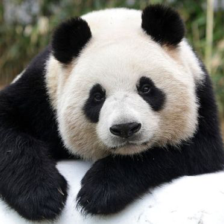

In [7]:
# панда классифицируется как панда

what_class_of_image(load_image('./data/adversarial/panda.jpg'))

293 cheetah chetah Acinonyx jubatus 0.9529044032096863


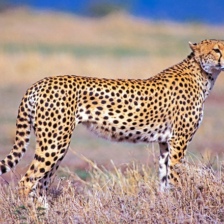

In [8]:
# а гепард, как гепард

what_class_of_image(load_image('./data/adversarial/cheetah.jpg'))

In [9]:
def adversarial_attack(image, target_class):
    # создадим копию изображения, которую будем оптимизировать
    image = image.clone().cuda().requires_grad_()
    
    # положим её в оптимизиатор (подойдёт, в приницпе, любой)
    optimizer = optim.Adam([image], lr=1e-3)

    for i in tqdm(range(40)):
        # предсказываем logits 
        # (если применить softmax, то получим вероятности)
        output = model(image.unsqueeze(0)).squeeze(0)
        
        # обнуляем градиенты
        optimizer.zero_grad()
        
        # считаем то, что хотим минимизировать
        loss = -output[target_class]
        
        # вычисляем градиенты
        loss.backward()
        
        # шаг оптимизации
        optimizer.step()
        
        # клипаем изображение, так как значения
        # пикселей могли выйти за границы
        image.data.clamp_(0, 1)
    
    # возращаем оптимизированные изображение
    return image.detach().cpu()


293 cheetah chetah Acinonyx jubatus 0.9639872312545776


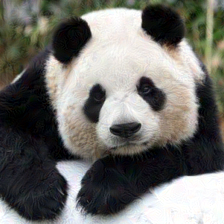

In [10]:
# панда превратилась в гепарда

PANDA_ID = 388
CHEETAH_ID = 293

source_image = load_image('./data/adversarial/panda.jpg')
attack_image = adversarial_attack(source_image, CHEETAH_ID)
what_class_of_image(attack_image)

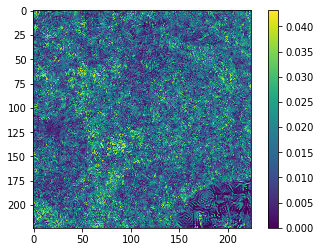

In [11]:
# считаем изменение, которое пришлось сделать

delta = attack_image - source_image
delta = np.abs(delta.numpy()).mean(axis=0)

plt.imshow(delta)
plt.colorbar()